### Facultad de Ciencias Exactas, Ingeniería y Agrimensura - UNR
## Tenicatura Universitaria en Inteligencia Artificial.


# Trabajo Práctico Final: Procesamiento de Lenguaje Natural.

- **Pace, Bruno. Legajo: P-5295/7.**

Docentes:
 - Manson, Juan Pablo.
 - Geary, Alan.
 - Sollberger, Dolores.
 - Ferrucci, Costantino.

Fecha de Entrega: 18 de diciembre de 2024.


In [1]:
%%capture
# Redis graph
!pip install redis redisgraph
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes


import redis
from redisgraph import Graph, Node, Edge
import matplotlib.pyplot as plt
import networkx as nx

# Selenium web scrapping
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!pip install selenium

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import os
os.environ["PATH"] += ":/usr/bin/chromedriver"

# Extracción de texto desde Documentos
!pip install PyPDF2
import PyPDF2

# Chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Visualización
import matplotlib.pyplot as plt
import networkx as nx

# DataFrame
import pandas as pd

# Requests (Descarga de PDF)
import requests

# YouTube Transcripción
!pip install youtube-transcript-api
from youtube_transcript_api import YouTubeTranscriptApi
import re

# Chromadb
!pip install chromadb
import chromadb

# Para tener id's en la chroma
import uuid

# Redes neuronales - Transformers
import torch
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Clasificador mediante regresión logística
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score


# Modelo de lenguaje HuggingFace (HF)
from huggingface_hub import InferenceClient

# data para API KEY
from google.colab import userdata


!pip install rank-bm25


# BM25 para rankear por palabra
from rank_bm25 import BM25Okapi

# Nltk para tokenización
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.data.path.append('/content/nltk_data')

# API - KEY
!pip install python-decouple

# Base de Datos de Grafo

## Web scrapping
Se obtiene información a través de Web Scrapping con Selenium.
Se tiene la siguiente información:
- Diseñadores.
- Artistas.
- Familia de Juegos.
- Mecanismos.
- Empresas que lo publicaron.
- Categorias.

In [2]:
url_grafo: str = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"
title: str = 'Rajas Of The Ganges'

In [3]:
def buscar_credito(data: str) -> tuple[dict[str, list[str]], dict[str,list[str]]]:
    """
    Retorna una tupla de diccionarios que contienen el(los) nombre(s) y el link(s) correspondiente(s)

    Args:
      data: str = el nombre del dato a buscar

    Returns:
      name_dict: dict[str, list[str]] = diccionario con los nombres.
      link_dict: dict[str, list[str]] = diccionario con los links.
    """
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    driver = webdriver.Chrome(service=Service(), options=chrome_options)
    driver.get(url_grafo)

    name_dict: dict[str, list[str]] = {f"{data}_nombre": []}
    link_dict: dict[str, list[str]] = {f"{data}_link": []}

    elements = driver.find_elements(By.XPATH, f'//a[contains(@ng-href, "/boardgame{data}/")]')

    if elements:
        for element in elements:
            name_dict[f"{data}_nombre"].append(element.text)
            link_dict[f"{data}_link"].append(element.get_attribute('href'))
    else:
        print(f"No se encontraron elementos para {data}")

    driver.quit()

    return name_dict, link_dict

data_designer: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("designer")
data_artist: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("artist")
data_family: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("family")
data_mechanic: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("mechanic")
data_publisher: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("publisher")
data_categories: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("category")

In [4]:
data_categories[0]

{'category_nombre': ['Dice', 'Economic', 'Renaissance', 'Territory Building']}

## Creación de BBDD de Grafos
Se utiliza Redis, por su simple implementación con Colab.

In [5]:
redis_client = redis.Redis(host='localhost', port=6379) # inicialización de Redis

In [6]:
def define_relation(label: str) -> str | None:
  """
  Define la relación entre el nodo titulo y el nodo que se quiere relacionar

  Args:
    label: str = el label del nodo que se quiere relacionar

  Returns:
    str | None = el label de la relación
  """
  if label == "Designer":
    return "Designed_by"
  elif label == "Artist":
    return "Created_by"
  elif label == "Family":
    return "Similar_to"
  elif label == "Mechanic":
    return "Mechanic"
  elif label == "Publisher":
    return "Published_by"
  elif label == "Category":
    return "Category"
  return None

In [7]:
def crear_nodos_with_edges(graph: Graph, data: dict[str, list[str]], main_node: Node) -> None:
    """
    Dado un diccionario con datos, crea los nodos correspondientes en un grafo
    de redis y añade las relaciones correspondientes.

    Args:
        graph: Redis graph instance.
        data: Dictionary containing names as lists under specific keys.
        main_node: The main node to relate new nodes with.

    Returns:
        None
    """
    if not data:
        print("Diccionario vacío")
        return

    for key, names in data[0].items():
        label = key.split("_")[0].capitalize()
        relation = define_relation(label)

        if not relation:
            print(f"Relación no definida para el label: {label}")
            continue

        for name in names:
            print(f'Creando nodo con nombre: {name} y label: {label}')
            node = Node(label=label, properties={"name": name})
            graph.add_node(node)

            print(f'Añadiendo relación: {relation}')
            edge = Edge(main_node, relation, node)
            edge.relation_type = relation
            graph.add_edge(edge)

    print("Nodos y relaciones creados exitosamente.")
    return None


In [8]:
graph = Graph('creditos', redis_client)

def create_all_nodes(graph: Graph) -> None:
  """
  Crea los nodos del grafo.
  Args:
    graph: grafo de redis.

  Returns:
    None
  """
  main_node = Node(label='title', properties={"name": title})
  graph.add_node(main_node)
  crear_nodos_with_edges(graph, data_designer, main_node)
  crear_nodos_with_edges(graph, data_artist, main_node)
  crear_nodos_with_edges(graph, data_family, main_node)
  crear_nodos_with_edges(graph, data_mechanic, main_node)
  crear_nodos_with_edges(graph, data_publisher, main_node)
  crear_nodos_with_edges(graph, data_categories, main_node)

  graph.commit()
  return None

create_all_nodes(graph)

Creando nodo con nombre: Inka Brand y label: Designer
Añadiendo relación: Designed_by
Creando nodo con nombre: Markus Brand y label: Designer
Añadiendo relación: Designed_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Dennis Lohausen y label: Artist
Añadiendo relación: Created_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Admin: Better Description Needed! y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Country: India y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Tabletopia y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Yucata y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Game: Rajas of the Ganges y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Mechanism: Dice Drafting y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Religious: Hinduism y label: Fa

In [9]:
def get_all_nodes(graph: Graph) -> list[dict]:
    """
    Devuelve todos los nodos del grafo

    Args:
        graph: grafo de redis

    Returns:
        Lista de diccionarios con id, label y properties de cada nodo.
    """
    query = "MATCH (n) RETURN n"
    result = graph.query(query)
    nodes: list = []

    for record in result.result_set:
        node = record[0]
        node_data = {
            "id": node.id,
            "label": node.label,
            "properties": node.properties
        }
        nodes.append(node_data)

    return nodes

all_nodes: list[dict] = get_all_nodes(graph)
for node in all_nodes:
    print(node)

{'id': 0, 'label': 'title', 'properties': {'name': 'Rajas Of The Ganges'}}
{'id': 1, 'label': 'Designer', 'properties': {'name': 'Inka Brand'}}
{'id': 2, 'label': 'Designer', 'properties': {'name': 'Markus Brand'}}
{'id': 3, 'label': 'Artist', 'properties': {'name': 'Dennis Lohausen'}}
{'id': 4, 'label': 'Family', 'properties': {'name': 'Admin: Better Description Needed!'}}
{'id': 5, 'label': 'Family', 'properties': {'name': 'Country: India'}}
{'id': 6, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Tabletopia'}}
{'id': 7, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Yucata'}}
{'id': 8, 'label': 'Family', 'properties': {'name': 'Game: Rajas of the Ganges'}}
{'id': 9, 'label': 'Family', 'properties': {'name': 'Mechanism: Dice Drafting'}}
{'id': 10, 'label': 'Family', 'properties': {'name': 'Religious: Hinduism'}}
{'id': 11, 'label': 'Mechanic', 'properties': {'name': 'Connections'}}
{'id': 12, 'label': 'Mechanic', 'properties': {'name': 'Dice 

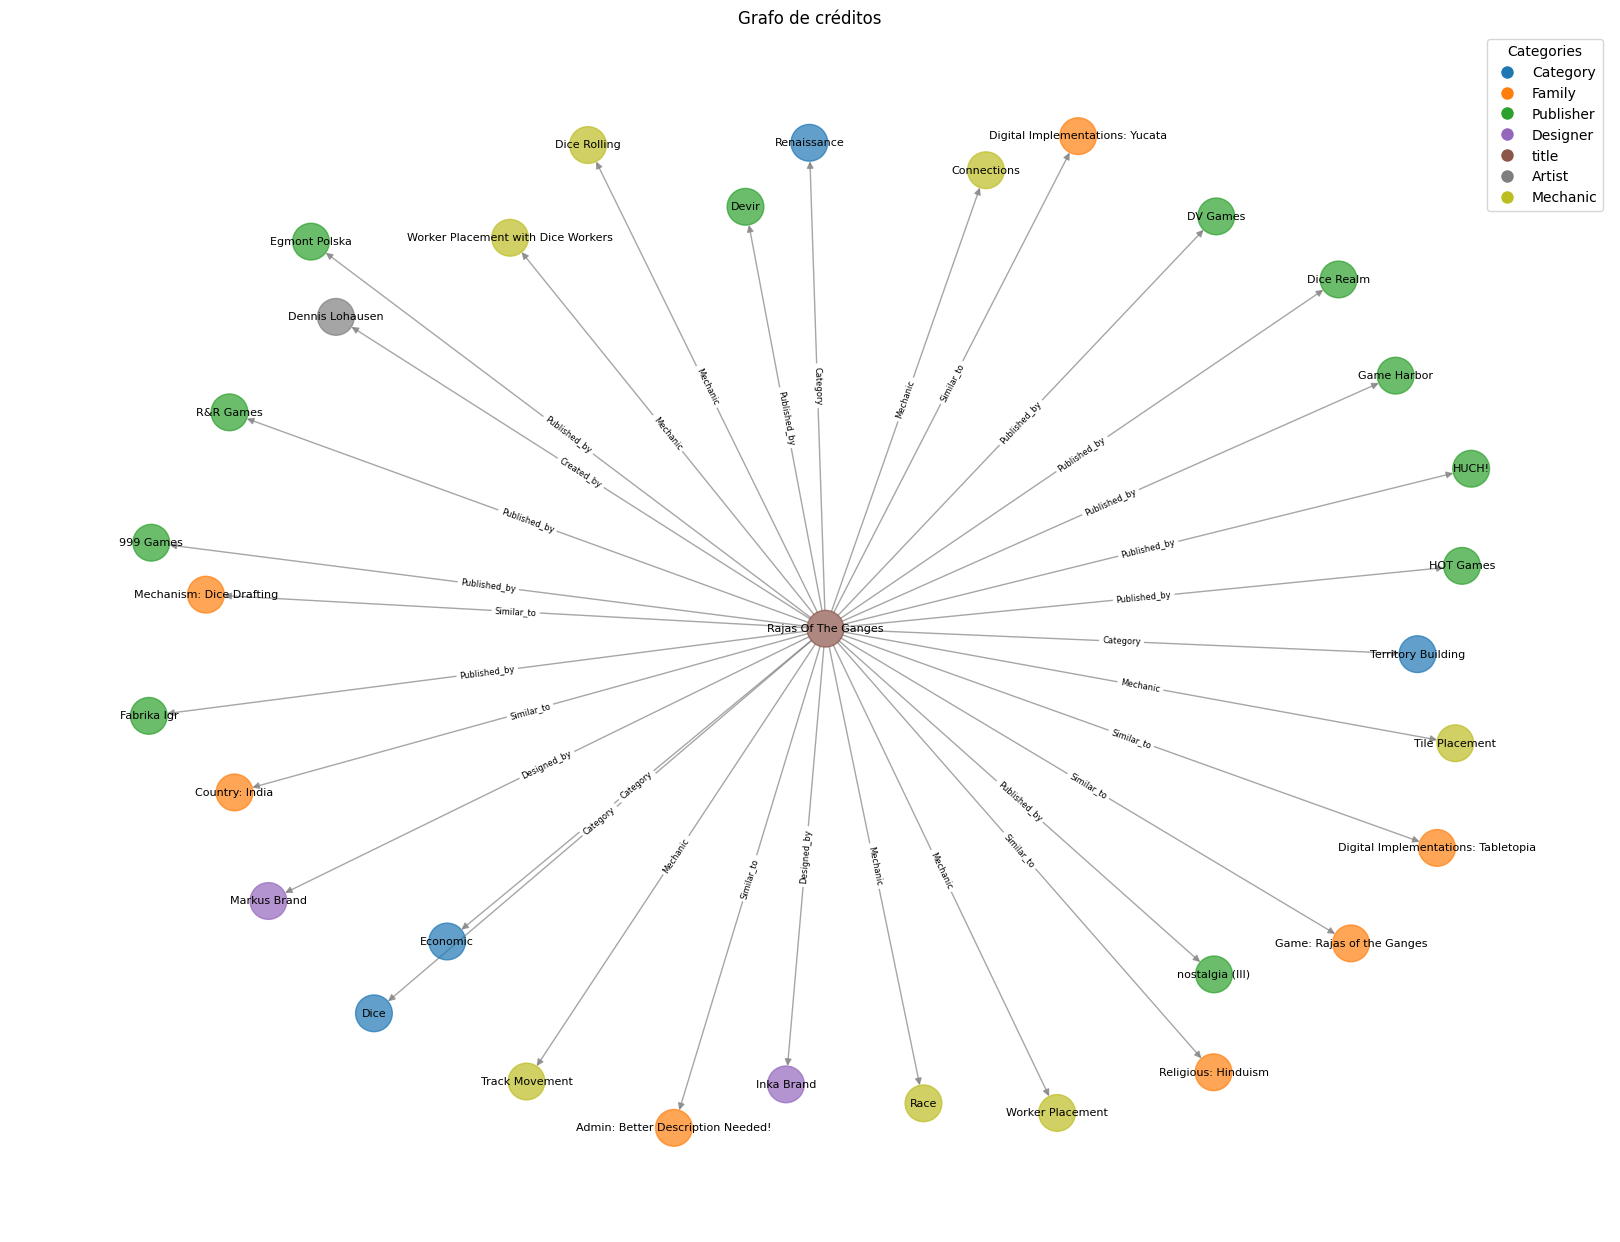

In [10]:
def plot_graph(graph: Graph) -> None:
    """
    Plot de un grafo de redis con sus relaciones.

    Args:
        graph: grafo de redis.

    Returns:
        None
    """
    nx_graph = nx.DiGraph()

    # Query nodes
    node_query = "MATCH (n) RETURN n"
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        node_id = node.id
        node_label = node.label
        node_name = node.properties.get("name", f"Node {node_id}")
        nx_graph.add_node(node_id, label=node_label, name=node_name, category=node_label)

    # Query edges
    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        src = record[0].id
        dest = record[2].id
        relationship = record[1]

        # Use `relation` instead of `relation_type` as defined earlier
        relation = getattr(relationship, 'relation', 'undefined')  # Default to 'undefined' if not set
        nx_graph.add_edge(src, dest, label=relation)

    # Plot graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(nx_graph, k=0.5)

    # Color nodes by category
    categories = nx.get_node_attributes(nx_graph, 'category')
    unique_categories = set(categories.values())
    node_colors = {cat: plt.cm.tab10(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    node_color_list = [node_colors[categories[node]] for node in nx_graph.nodes()]

    nx.draw(
        nx_graph, pos,
        with_labels=False,
        node_size=700,
        node_color=node_color_list,
        edge_color='gray',
        alpha=0.7
    )

    # Add labels
    node_labels = {node: data['name'] for node, data in nx_graph.nodes(data=True)}
    nx.draw_networkx_labels(nx_graph, pos, labels=node_labels, font_size=8, font_color='black')

    edge_labels = nx.get_edge_attributes(nx_graph, "label")
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)

    # Add legend
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat)
                     for cat, color in node_colors.items()]
    plt.legend(handles=legend_labels, loc='best', title='Categories')

    plt.title("Grafo de créditos")
    plt.show()

plot_graph(graph)

In [11]:
def get_graph_data(graph: Graph) -> dict:
    """
    Devuelve nodos y relaciones del grafo de Redis.

    Args:
        graph: grafo de redis.

    Returns:
        diccionario de nodos y relaciones.
    """
    graph_data = {
        "nodes": [],
        "relationships": []
    }

    # Query to fetch all nodes
    node_query = "MATCH (n) RETURN n"
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        node_id = node.id
        node_label = node.label
        node_properties = node.properties
        graph_data["nodes"].append({
            "id": node_id,
            "label": node_label,
            "properties": node_properties
        })

    # Query to fetch all relationships
    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        src = record[0].id
        dest = record[2].id
        relationship = record[1]

        # Safely get attributes from the relationship
        relation_type = getattr(relationship, 'relation', 'undefined')  # Default to 'undefined' if not set
        relation_properties = getattr(relationship, 'properties', {})  # Default to empty dict if not set

        graph_data["relationships"].append({
            "source": src,
            "target": dest,
            "type": relation_type,
            "properties": relation_properties
        })

    return graph_data

# Example usage:
graph_data: dict = get_graph_data(graph)
print(graph_data)


{'nodes': [{'id': 0, 'label': 'title', 'properties': {'name': 'Rajas Of The Ganges'}}, {'id': 1, 'label': 'Designer', 'properties': {'name': 'Inka Brand'}}, {'id': 2, 'label': 'Designer', 'properties': {'name': 'Markus Brand'}}, {'id': 3, 'label': 'Artist', 'properties': {'name': 'Dennis Lohausen'}}, {'id': 4, 'label': 'Family', 'properties': {'name': 'Admin: Better Description Needed!'}}, {'id': 5, 'label': 'Family', 'properties': {'name': 'Country: India'}}, {'id': 6, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Tabletopia'}}, {'id': 7, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Yucata'}}, {'id': 8, 'label': 'Family', 'properties': {'name': 'Game: Rajas of the Ganges'}}, {'id': 9, 'label': 'Family', 'properties': {'name': 'Mechanism: Dice Drafting'}}, {'id': 10, 'label': 'Family', 'properties': {'name': 'Religious: Hinduism'}}, {'id': 11, 'label': 'Mechanic', 'properties': {'name': 'Connections'}}, {'id': 12, 'label': 'Mechanic', 'prope

# BBDD Tabular

In [12]:
url_stats: str = 'https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/stats'

In [13]:
def get_stats(url: str) -> dict:
    """
    Dado un URL obtiene las estadisticas de un juego.

    Args:
        url: URL de las estadísticas.

    Returns:
        Diccionario con las estadisticas.
    """
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(service=Service(), options=chrome_options)
    driver.get(url)

    stats: dict[str, dict[str, str]] = {}

    try:
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'li.outline-item')))

        elements = driver.find_elements(By.CSS_SELECTOR, 'li.outline-item')



        for element in elements:
            main_text_element = element.find_element(By.CSS_SELECTOR, 'div.outline-item-title')
            main_text = main_text_element.text.strip()

            #stats[main_text] = {}

            sub_value = element.find_element(By.CSS_SELECTOR, 'div.outline-item-description').text.strip()

            stats[main_text] = sub_value

    except Exception as e:
        print(f"Error extracting stats: {e}")
    finally:
        driver.quit()

    return stats

stats = get_stats(url_stats)
print(stats)


{'Avg. Rating': '7.731', 'No. of Ratings': '14,698', 'Std. Deviation': '1.13', 'Weight': '2.89 / 5', 'Comments': '2,124', 'Fans': '691', 'Page Views': '899,384', 'Overall Rank': '156\nHistorical Rank', 'Strategy Rank': '123\nHistorical Rank', 'All Time Plays': '59,431', 'This Month': '222', 'Own': '19,555', 'Prev. Owned': '2,055', 'For Trade': '194\nFind For-Trade Matches', 'Want In Trade': '677\nFind Want-in-Trade Matches', 'Wishlist': '3,812', 'Has Parts': '11', 'Want Parts': '4'}


In [14]:
df_stats: pd.DataFrame = pd.DataFrame(stats, index=[0])
df_stats

,Avg. Rating,No. of Ratings,Std. Deviation,Weight,Comments,Fans,Page Views,Overall Rank,Strategy Rank,All Time Plays,This Month,Own,Prev. Owned,For Trade,Want In Trade,Wishlist,Has Parts,Want Parts
0,7.731,"14,698",1.13,2.89 / 5,"2,124",691,"899,384",156\nHistorical Rank,123\nHistorical Rank,"59,431",222,"19,555","2,055",194\nFind For-Trade Matches,677\nFind Want-in-Trade Matches,"3,812",11,4


In [15]:
df_stats.columns

Index(['Avg. Rating', 'No. of Ratings', 'Std. Deviation', 'Weight', 'Comments',
       'Fans', 'Page Views', 'Overall Rank', 'Strategy Rank', 'All Time Plays',
       'This Month', 'Own', 'Prev. Owned', 'For Trade', 'Want In Trade',
       'Wishlist', 'Has Parts', 'Want Parts'],
      dtype='object')

In [16]:
columns_renamed: dict[str, str] = {
    'Avg. Rating': 'average_rating',
    'No. of Ratings': 'number_of_rating',
    'Std. Deviation' : 'std',
    'Weight' : 'weight',
    'Comments' : 'comments',
    'Fans' : 'fans',
    'Page Views' : 'page_views',
    'Overall Rank': 'overall_rank',
    'Strategy Rank' : 'strategy_rank',
    'All Time Plays' : 'all_time_plays',
    'This Month' : 'this_month',
    'Own': 'players',
    'Prev. Owned' : 'ex_players',
    'For Trade' : 'items_for_trade',
    'Want In Trade' : 'items_want_in_trade',
    'Wishlist' : 'wishlist',
    'Has Parts' :'people_who_has_parts_to_exchange',
    'Want Parts' : 'people_who_want_parts_to_exchange'

}

df_stats_renamed = pd.DataFrame(df_stats.rename(columns=columns_renamed))
df_stats_renamed

,average_rating,number_of_rating,std,weight,comments,fans,page_views,overall_rank,strategy_rank,all_time_plays,this_month,players,ex_players,items_for_trade,items_want_in_trade,wishlist,people_who_has_parts_to_exchange,people_who_want_parts_to_exchange
0,7.731,"14,698",1.13,2.89 / 5,"2,124",691,"899,384",156\nHistorical Rank,123\nHistorical Rank,"59,431",222,"19,555","2,055",194\nFind For-Trade Matches,677\nFind Want-in-Trade Matches,"3,812",11,4


In [17]:
columns_with_noise: list[str] = ['items_for_trade','overall_rank','strategy_rank','items_want_in_trade']

def delete_noise(column: str) -> str:
  """
  dado un str, devuelve las primeras tres letras.

  Args:
    column: str a hacer el slice

  Returns:
    str con las primeras tres letras.
  """
  return column[:3]

df_stats_cleaned: pd.DataFrame = df_stats_renamed.copy()

for column in columns_with_noise:
  df_stats_cleaned[column] = df_stats_cleaned[column].apply(delete_noise)

df_stats_cleaned

,average_rating,number_of_rating,std,weight,comments,fans,page_views,overall_rank,strategy_rank,all_time_plays,this_month,players,ex_players,items_for_trade,items_want_in_trade,wishlist,people_who_has_parts_to_exchange,people_who_want_parts_to_exchange
0,7.731,"14,698",1.13,2.89 / 5,"2,124",691,"899,384",156,123,"59,431",222,"19,555","2,055",194,677,"3,812",11,4


In [18]:
df_stats_long: pd.DataFrame = pd.melt(df_stats_cleaned, var_name='Stat', value_name='Value')

df_stats_long

,Stat,Value
0,average_rating,7.731
1,number_of_rating,"14,698"
2,std,1.13
3,weight,2.89 / 5
4,comments,"2,124"
5,fans,691
6,page_views,"899,384"
7,overall_rank,156
8,strategy_rank,123
9,all_time_plays,"59,431"


# Documentos de texto

In [19]:
def get_pdf(url: str, filename: str) -> None:
  """
  Dado un url de un pdf y un nombre para almacenarlo, lo descarga y lo guarda.

  Args:
    url: url del pdf.
    filename: nombre del pdf.

  Returns:
    None
  """
  response = requests.get(url)
  if response.status_code == 200:
      with open(f'{filename}.pdf', "wb") as file:
          file.write(response.content)
      print(f"PDF {filename} downloaded successfully.")
  else:
      print(f"Failed to download the {filename} PDF.")
  return None

get_pdf('https://github.com/bpace1/TUIA---NLP/raw/047d8fd1402bd9e65122f36381316e7074361023/TP2-Final/data/review.pdf', 'review')
get_pdf('https://github.com/bpace1/TUIA---NLP/raw/047d8fd1402bd9e65122f36381316e7074361023/TP2-Final/data/rulebook.pdf', 'rulebook')
#get_pdf('https://github.com/bpace1/TUIA---NLP/raw/3a4f040c549ba9912a7439728da62d54d7c321e0/TP2-Final/data/automa.pdf', 'automa')
get_pdf('https://github.com/bpace1/TUIA---NLP/raw/main/TP2-Final/data/simple_explanation.pdf', 'simple_explanation')

PDF review downloaded successfully.
PDF rulebook downloaded successfully.
PDF simple_explanation downloaded successfully.


In [20]:
def pdf_to_text(pdf_path: str) -> str:
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)

        text = ''
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            page_text = page.extract_text()

            filtered_text = ' '.join(line for line in page_text.split('\n') if len(line.strip()) >= 3)

            text += filtered_text + ' '

        return text.strip()

review_text: str = pdf_to_text('review.pdf')
rulebook_text: str = pdf_to_text('rulebook.pdf')
#automa_text: str = pdf_to_text('automa.pdf')
simple_explanation_text: str = pdf_to_text('simple_explanation.pdf')

In [21]:
rulebook_text

'India in the era of the aspiring Mogul empire. New lands are being gained along with great prosperity attained through the trading of silk, tea, and  spices. Imposing structures such as the Taj Mahal and the Red Fort are built, and gorgeous gardens are created alongside new buildings and parks  that will impress generations to come even centuries later. At a time when the empire has almost reached its greatest dimensions and is in a phase of relative stability, players, representing rajas and ranis,  are called upon to live up to the requirements of their role as venerable sovereigns. They must improve their estates into magnificent and wealthy  provinces. Keeping in mind the important role of karma, players balance their growth in a demanding interplay of prestige and prosperity. The one  with the most successful outcome will truly become one of the nation’s legendary leaders. For 2 to 4 players, 12 years and up Contents  Object of the Game Your task is to develop your province with 

# Transcripción de Videos de Youtube
- [¿Cómo se juega?](https://www.youtube.com/watch?v=OJ0anCDdIJ4&t=21s)
- [Review](https://www.youtube.com/watch?v=3-Vo-0Cv9Pk)

Se utiliza la api de transcripción de YouTube.



In [22]:
def transcribe_yt_video(url: str) -> str:
    """
    Dado un URL de un video de YouTube, obtiene los subtítulos.

    Args:
        url: URL del video.

    Returns:
        Texto de los subtítulos.
    """
    try:
        video_id_match = re.search(r"v=([a-zA-Z0-9_-]+)", url)
        if video_id_match:
            video_id = video_id_match.group(1)
        else:
            raise ValueError("No se pudo extraer el ID del video de la URL.")

        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        text = " ".join([entry['text'] for entry in transcript])

        text = text.replace('\n', ' ').strip()

        return text

    except Exception as e:
        print("Error:", e)

how_to_play_video: str = transcribe_yt_video('https://www.youtube.com/watch?v=OJ0anCDdIJ4&t=21s')
review_video: str = transcribe_yt_video('https://www.youtube.com/watch?v=3-Vo-0Cv9Pk')
gameplay_video: str = transcribe_yt_video('https://www.youtube.com/watch?v=ruScGyu1_5w')


In [23]:
gameplay_video

"hi everyone my name is modi and i'm naveen from before you play and today we are going to be doing a playthrough of rogers of the ganges now this is a game that was requested by one of our longtime patreon supporters an executive producer so thank you so much for that this one's designed by two different designers inca and marcus brand and it is published by r r games and hooch and it is a two to four player very euro style game and so we are pretty excited to showcase it today it's interesting because it is definitely a heroes style game but there is some dice rolling there is yup there's quite a bit of dice rolling and so in this game we're going to be building up our province uh in india we're trying to earn a lot of money and fame at the same time and as per usual we are going to start with an overview of how the game is played then we're going to go into our playthrough and then our review of it and so if you're interested in jumping around we will include time stamps down below 

In [24]:
review_video

"and now it's time for another diced our review with Tom vassal hey folks I'm Tom vassal and today we're taking a look at a game by incus and Marcus brand called the Rajah's of the Ganges now the brands have been turning into my favorite duo of designers they've made some really great games this year they made the exit games they made a great party game just good stuff across the board so today we're taking a look at this game here when which what is the theme of this game in 16th century India you are being some Raja and you are going to basically be influential in your area okay a lot of the the hootch games don't really necessarily the theme doesn't matter it's all about mechanisms this one has dice in it dice as a resource in the game and you're going to also beat it has an interesting method of victory where to victory point tracks are going to cross here's how plays okay so here's the board and we want to talk about is there's two tracks on the board there's a thing track you'll 

In [25]:
how_to_play_video

"Hello and welcome to another episode of how to play by Cat House Gaming. Our goal in this series is to give you and your tablemates the foundational game mechanics needed to you playing in a short amount of time. I know you'd rather be gaming so let's get started. Hey guys today's game is Rajas of the Ganges. In Rajas of the Ganges each player is Indian royalty tasked with improving their estates into wealthy provinces through the trading of silk, tea, and spices as well as by building impressive structures to awe current and future generations. Rajas of the Ganges is a game for two to four players combining several game mechanics including worker placement, tile laying, and dice rolling. It has an interesting end game trigger and scoring mechanism. End game is triggered when a user's fame marker passes their money marker. The current stage and not the round is completed which means that all players between the person who triggered end game and the person with with the start player ma

# Base de Datos Vectorial

In [26]:
def get_chunks(text: str, chunk_size: int = 500, chunk_overlap: int = 50) -> list[str]:
  """
  Dado un texto, un tamaño de chunk y una superposición, devuelve una lista de chunks

  Args:
    text: texto a dividir.
    chunk_size: tamaño del chunk.
    chunk_overlap: superposición entre chunks.

  Returns:
    Lista de chunks.
  """
  splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  chunks = splitter.split_text(text)
  return chunks

In [27]:
chunks_review: list[str] = get_chunks(review_text)
chunks_rulebook: list[str] = get_chunks(rulebook_text)
#chunks_automa: list[str] = get_chunks(automa_text)
chunks_simple_explanation: list[str] = get_chunks(simple_explanation_text)

chunks_video_review: list[str] = get_chunks(review_video)
chunks_video_gameplay: list[str] = get_chunks(gameplay_video)
chunks_video_how_to_play: list[str] = get_chunks(how_to_play_video)

In [28]:
for chunk in chunks_video_gameplay:
  print(chunk)
  print('\n')

hi everyone my name is modi and i'm naveen from before you play and today we are going to be doing a playthrough of rogers of the ganges now this is a game that was requested by one of our longtime patreon supporters an executive producer so thank you so much for that this one's designed by two different designers inca and marcus brand and it is published by r r games and hooch and it is a two to four player very euro style game and so we are pretty excited to showcase it today it's interesting


excited to showcase it today it's interesting because it is definitely a heroes style game but there is some dice rolling there is yup there's quite a bit of dice rolling and so in this game we're going to be building up our province uh in india we're trying to earn a lot of money and fame at the same time and as per usual we are going to start with an overview of how the game is played then we're going to go into our playthrough and then our review of it and so if you're interested in jumping

In [29]:
#total_chunks: list[list[str]] = [review_text ,chunks_automa, chunks_simple_explanation, chunks_rulebook, chunks_video_review, chunks_video_gameplay, chunks_video_how_to_play]
total_chunks: list[list[str]] = [review_text , chunks_simple_explanation, chunks_rulebook, chunks_video_review, chunks_video_gameplay, chunks_video_how_to_play]

Inicialización de chroma con explicación en [Medium](https://gdevakumar-medium-com.translate.goog/quickstart-guide-to-vector-databases-using-chromadb-52587f75cf7f?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc&_x_tr_hist=true)

In [30]:
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

def get_embedding_2(chunk: str) -> np.ndarray:
    """
    Convierte un fragmento de texto (chunk) en un embedding utilizando SentenceTransformer.

    Args:
        chunk: Un fragmento de texto (string).

    Returns:
        Un embedding del chunk de texto como un vector numpy.
    """
    # Generate the embedding using SentenceTransformer
    embedding = modelo.encode(chunk, convert_to_numpy=True)

    return embedding


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

https://sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html

In [ ]:
embedding_model_name = "intfloat/multilingual-e5-large"
#embedding_model_name = "embed-english-v3.0"
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
model = AutoModel.from_pretrained(embedding_model_name)

def get_embedding(chunk: str) -> torch.Tensor:
    """
    Convierte un fragmento de texto (chunk) en un embedding utilizando un modelo de transformers.

    Args:
        chunk: Un fragmento de texto (string).

    Returns:
        Un embedding del chunk de texto como un tensor.
    """
    inputs = tokenizer(chunk, return_tensors="pt", truncation=True, padding=True, max_length=512) #convierte a numérico

    with torch.no_grad():
        outputs = model(**inputs)

    embedding = outputs.last_hidden_state[:, 0, :]
    return embedding.squeeze().numpy()


def add_to_chroma(collection: chromadb.Collection, chunks: list[str], embedding_model) -> None:
    """
    Dado una colección de Chroma y una lista de chunks, los añade a la colección junto con sus embeddings.

    Args:
      collection: colección de Chroma.
      chunks: lista de chunks.
      embedding_model: modelo para generar los embeddings.

    Returns:
      None
    """
    for chunk in chunks:
        chunk_id = str(uuid.uuid4())  # Generar un ID único

        embedding = get_embedding(chunk)

        collection.add(
            documents=[chunk],      # El texto del chunk
            embeddings=[embedding],  # El embedding generado
            metadatas=[{"id": chunk_id}],  # Metadatos con el ID
            ids=[chunk_id]          # ID único para el chunk
        )
    return None

def add_all_chunks(list_of_chunks: list[list[str]], collection: chromadb.Collection, embedding_model) -> None:
    """
    Dado una lista de listas de chunks, inserta sus embeddings en la colección de Chroma.

    Args:
      list_of_chunks: lista de listas de chunks de texto.
      collection: colección de Chroma.
      embedding_model: modelo para generar los embeddings.

    Returns:
      None
    """
    for chunks in list_of_chunks:
        add_to_chroma(collection, chunks, embedding_model)  # Insertar los chunks y sus embeddings
    return None

chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name="game_embeddings")


add_all_chunks(total_chunks, collection, embedding_model_name)


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

# Clasificadores

Se obtiene un rendimiento significativamente superior en el caso del clasificador hecho con Hugging Face. Se utiliza para comparar principalmente el F1-score.

F1-score al tener en cuenta el recall y la precision, es el indicado para comparar ambos modelos. Queremos diferenciar bien las clases, lo que nos llevará a un mejor rendimiento del RAG.

Rendimiento:
- Logistic-Regression: 0.70
- HF qwen: 0.92

## Clasificador : basado en ejemplos y embeddings.

In [ ]:
classification_examples: pd.DataFrame = pd.DataFrame({
    "prompt": [
        "How do I play?", "What are the game rules?", "Explain the rulebook.",  #3
        "What happens if...?", "Can you explain the setup?", "What is the objective of the game?", #3
        "What are the winning conditions?", "How do I resolve conflicts in the game?", "What happens during a tie?", #3
        "What is the sequence of turns?", "What is the penalty for breaking a rule?", "Can you explain advanced rules?", #3
        "What are common beginner mistakes?", "How do I use special cards?", "What happens if a player leaves mid-game?", #3
        "Can I modify the rules?", "How are disputes settled?", "What are the house rules options?", "Is there a time limit per turn?", #4

        "What is your opinion about the game?", "What do people say about the game?", "Are there any reviews available?",
        "What do players think?", "Is the game worth buying?", "What are the pros and cons of the game?",
        "What do reviewers say about the game theme?", "Are there any complaints about the game?", "What are the most praised aspects of the game?",
        "What do experienced players think about it?", "How does this game compare to others in its genre?", "What are the critical reviews highlighting?",
        "Is the game recommended for families?", "What are the reviews for expansions?", "Does the game hold replay value?",
        "What is the most common feedback?", "Are there any awards mentioned in reviews?", "What are the opinions on the artwork?",
        "How do players rate the components?", "What themes do players find immersive?",

        "How is the gameplay?", "What is the experience of playing?", "Is the game engaging?", "How does the game flow?",
        "How long does a typical game last?", "What strategies are effective?", "Is the game beginner-friendly?",
        "What is the difficulty level?", "Are there any memorable moments during gameplay?", "How does the game scale with more players?",
        "Is there downtime between turns?", "What is the best player count?", "Are there cooperative elements?",
        "How do expansions affect gameplay?", "Are there any hidden mechanics?", "How does randomness affect gameplay?",
        "What are the key decision points?", "Does the game have replayability?", "Are there player elimination mechanics?",
        "How does the game balance different strategies?",

        "How many players played this month?", "What is the average rating?", "How many items are available for trade?",
        "What is the rank of this game?", "How many fans does the game have?", "How many people have this game on their wishlist?",
        "What is the overall rank of the game?", "What is the strategy rank of the game?", "How many page views does the game have?",
        "What is the standard deviation of ratings?", "How many copies of the game were sold last year?", "What is the retention rate of players?",
        "What are the top-rated games in the same category?", "What is the growth rate of interest in the game?", "How many reviews mention the artwork?",
        "What is the average playtime reported?", "How does the game rank in its genre?", "What is the peak player count this year?",
        "What is the percentage of positive reviews?", "How many expansions are available?",

        "Who designed the game?", "Who published the game?", "What is the main mechanic?", "What are the game categories?",
        "Who is the author of the game?", "What is the theme of the game?", "Which company published this game?", "What is the inspiration behind the game mechanics?",
        "What are the awards won by the game?", "Who developed the expansion packs?", "What partnerships were involved in publishing?",
        "Who owns the intellectual property rights?", "What are the licensing details?", "Which designers collaborated on this game?",
        "What are the notable influences on the game?", "Who created the promotional material?"
    ],
    "label": [
        "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules",
        "rules", "rules", "rules", "rules", "rules", "rules", "rules",

        "review", "review", "review", "review", "review", "review", "review", "review", "review", "review", "review",
        "review", "review", "review", "review", "review", "review", "review", "review", "review",

        "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay",
        "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay",
        "gameplay", "gameplay",

        "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats",
        "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats",

        "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph",
        "graph", "graph", "graph", "graph"
    ]
})

classification_examples.sample(5)


In [ ]:
classification_examples.info()

Separo df para poder entrenar el modelo

In [ ]:
X_classification: pd.DataFrame = classification_examples[['prompt']]
X_classification = X_classification['prompt'].apply(lambda x: x.lower())

y_classification: pd.DataFrame = classification_examples[['label']]

X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification,stratify=classification_examples['label'], test_size=0.2, random_state=42)

classification_vectorized: TfidfVectorizer = TfidfVectorizer()
X_train_vectorized = classification_vectorized.fit_transform(X_train)
X_test_vectorized = classification_vectorized.transform(X_test)

modelo_LR = LogisticRegression(multi_class='multinomial', solver='lbfgs')
modelo_LR.fit(X_train_vectorized, y_train)

y_pred_lr = modelo_LR.predict(X_test_vectorized)
print(classification_report(y_test, y_pred_lr))

## Clasificador: LLM



In [ ]:
def get_class(prompt: str) -> str:
    """
    Dado un prompt, lo clasifica como: rules, review, stats, graph o  gameplay.

    Args:
      prompt: prompt a clasificar.

    Returns:
      La clase del prompt.
    """
    client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    labels: list[str] = [
        "review", "rules", "graph", "stats", "gameplay"
    ]

    chat_prompt = [{
        "role": "system",
        "content": f'You are a classification model that has the following labels: [{", ".join(labels)}]. '
                   'You receive a prompt and you have to return only the label. '
                   'You cannot return a label that is not in the list mentioned before. '
                   'DO NOT returns more than one word.'
                   'the return review, graph and gameplay MUST BE singular'
                   'the return rules and stats MUST BE plural'
                   "Example 1: 'How many players played this month?' Return: 'stats'. "
                   "Example 2: 'Who designed the game?' Return: 'graph'. "
                   "Example 3: 'What is the experience of playing?' Return: 'gameplay'. "
                   "Example 4: 'What are the game rules?' Return: 'rules'. "
                   "Example 5: 'What is the average rating?' Return: 'stats'. "
                   "Example 6: 'What themes do players find immersive?' Return: 'review' "
                   "Example 7: 'How do I play?' Return: 'rules'"
    },
    {
        "role": "user",
        "content": prompt
    }]

    completion = client_HF.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=chat_prompt,
        max_tokens=50,
        temperature=0.1
    )

    return completion.choices[0].message['content'].strip()

Se prueba el rendimiento del modelo con el mismo dataset con el que se hizo el modelo de Logistic Regression.

In [ ]:
# Sample test data with true classifications
test_data: dict[str, str] = {
    "What are the game rules?": "rules",
    "Explain the rulebook.": "rules",
    "What happens if...?": "rules",
    "Can you explain the setup?": "rules",
    "What is the objective of the game?": "rules",
    "What is your opinion about the game?": "review",
    "What do people say about the game?": "review",
    "Are there any reviews available?": "review",
    "What do players think?": "review",
    "Is the game worth buying?": "review",
    "How is the gameplay?": "gameplay",
    "What is the experience of playing?": "gameplay",
    "Is the game engaging?": "gameplay",
    "How does the game flow?": "gameplay",
    "How long does a typical game last?": "gameplay",
    "What is the average rating?": "stats",
    "How many items are available for trade?": "stats",
    "What is the rank of this game?": "stats",
    "How many fans does the game have?": "stats",
    "Who designed the game?": "graph",
    "Who published the game?": "graph",
    "What is the main mechanic?": "graph",
    "What are the game categories?": "graph",
    "Who is the author of the game?": "graph",
}

prompts: list[str] = list(test_data.keys())
true_labels: list[str] = list(test_data.values())
predictions: list[str] = []

for prompt in prompts:
    try:
        classification = get_class(prompt)
        predictions.append(classification)
    except Exception as e:
        predictions.append("error")


print("Classification Report:")
print(classification_report(true_labels, predictions, zero_division=0))

f1 = f1_score(true_labels, predictions, average="macro", zero_division=0)
print(f"\nWeighted F1-Score: {f1:.4f}")

print("\nPredicted Labels:")
print(predictions)



# Querys dinámicas

## Query de grafo

In [ ]:
def get_graph_query(prompt: str, graph_data: dict) -> str:
    """
    Dado un prompt, genera una query de Redis para buscar en el grafo.

    Args:
        prompt (str): Pregunta del usuario sobre el grafo.
        graph_data (dict): Información del grafo en formato diccionario.

    Returns:
        str: Query generada en Cypher.
    """
    # Inicialización del cliente de Hugging Face
    client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    # Mensajes para el modelo
    messages = [
        {
            "role": "system",
            "content": f"""You are a query generator for RedisGraph using Cypher language.
            The user prompt is: '{prompt}'. The graph data is: {graph_data}.
            Return ONLY the query without explanations or additional text. Examples:
            - User prompt: "Who designed the game?"
              Response: MATCH (title:title {{name: "Rajas Of The Ganges"}})-[:Designed_by]->(designer:Designer) RETURN designer
            - User prompt: "What are the mechanics of the game?"
              Response: MATCH (title:title {{name: "Rajas Of The Ganges"}})-[:Mechanic]->(mechanic:Mechanic) RETURN mechanic
            """
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    # Llamada al modelo
    try:
        completion = client_HF.chat.completions.create(
            model="Qwen/Qwen2.5-Coder-32B-Instruct",
            messages=messages,
            max_tokens=500
        )

        # Extraer la respuesta
        respuesta = completion['choices'][0]['message']['content'].strip()
        return respuesta

    except Exception as e:
        print(f"Error al generar la query: {e}")
        return ""


# Example usage
designers_query: str = get_graph_query('who designed the game?', graph_data)
print(designers_query)

mechanics_query: str = get_graph_query('what are the mechanics of the game?', graph_data)
print(mechanics_query)

categories_query: str = get_graph_query('what are the categories of the game?', graph_data)
print(categories_query)

https://www.reddit.com/r/LocalLLaMA/comments/1gqfzdh/qwen_25_32b_coder_instruct_vs_72b_instruct/?tl=es-es

In [ ]:
results_querys: list[str] = [designers_query, mechanics_query, categories_query]

def graph_retriever(prompt):
    """
    Executes multiple queries on a graph and returns a dictionary with nodes, labels, and properties.

    Args:
        graph: The graph object to query.
        queries: A list of queries to execute.

    Returns:
        dict: A dictionary where keys are node IDs and values are dictionaries of labels and properties.
    """
    nodes_dict = {}

    query = get_graph_query(prompt, graph_data)

    result = graph.query(query)

    exit_list: list[str] = []
    if result.result_set:
        for record in result.result_set:
            node = record[0]
            exit_list.append(node.properties.get('name'))

    else:
        print("No se encontraron resultados en el grafo para la consulta:", query)

    return exit_list

graph_retriever('what are the categories of the game?')


## Query de DataFrame - Retriever

In [ ]:
print(df_stats_long)

In [ ]:
def get_df_query(prompt: str, df: pd.DataFrame) -> str:
    """
    Dado un prompt, genera una query para buscar en un dataframe de estadísticas.

    Args:
        prompt (str): Pregunta del usuario sobre el grafo.
        df (pd.DataFrame): DataFrame con la información de estadísticas.

    Returns:
        str: query (df.loc).
    """
    # Inicialización del cliente de Hugging Face
    client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    # Mensajes para el modelo
    messages = [
        {
            "role": "system",
            "content": f"""You are a query generator for a DataFrame containing statistics.
            The DataFrame is: {df}.
            The user prompt is: '{prompt}'. The DataFrame has the following columns:
            - Stat: The name of the statistic.
            - Value: The value of the statistic.
            Based on the question, generate a query that matches the statistic in the DataFrame and returns its value. Examples:
            - User prompt: What is the average rating?
              Response: df.loc[df['Stat'] == 'average_rating', 'Value']
            - User prompt: How many comments are there?
              Response: df.loc[df['Stat'] == 'comments', 'Value']
            """
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    try:
        completion = client_HF.chat.completions.create(
            model="Qwen/Qwen2.5-Coder-32B-Instruct",
            messages=messages,
            max_tokens=500
        )

        query = completion['choices'][0]['message']['content'].strip()
        return query

    except Exception as e:
        print(f"Error generating the query: {e}")
        return ""


# Example usage:
average_rating_query: str = get_df_query('What is the average rating?', df_stats_long)
print(average_rating_query)

number_of_rating_query: str = get_df_query('How many ratings are there?', df_stats_long)
print(number_of_rating_query)

players_this_month_query: str = get_df_query('How many players played this month?', df_stats_long)
print(players_this_month_query)


In [ ]:
def df_retriever(prompt: str, df: pd.DataFrame) -> str | None :
    """
    dado un prompt y un df, filtra el df mediante una query generada automáticamente.

    Args:
        prompt (str): prompt del usuario
        df (pd.DataFrame): DataFrame.

    Returns:
        str del resultado.
    """
    # Generate the query string
    query_str = get_df_query(prompt, df)

    try:
        # Execute the query
        result = eval(query_str)
        if result.empty:
            print("No matching rows found for the query:", query_str)
        return result

    except Exception as e:
        print(f"Error executing the query: {e}")
        return None  # Return an empty DataFrame on error

# Filter with a prompt
return_df = df_retriever("How many ratings are there?", df_stats_long)
print(return_df)


# Query documentos de Chroma

## Búsqueda semántica

Se utiliza la función get_embedding y la query por defecto de chroma para buscar los documentos.

In [ ]:
def get_semantic_similarity(prompt: str) -> tuple[list[str], list[float]]:
  """
  Dado un prompt, obtiene su embedding y realiza una búsqueda semántica en Chroma.

  Args:
    prompt: prompt del usuario.

  Returns:
    documentos similares y distancias.
  """
  embedding_prompt = get_embedding_2(prompt)
  results = collection.query(
      query_embeddings=[embedding_prompt],
      n_results=10
  )

  return results['documents'], results['distances']

## Búsqueda por palabras claves

Se utiliza BM25

In [ ]:
all_documents:list[str] = collection.get()['documents']

In [ ]:
def phrase_to_token(phrase: str) -> list[str]:
  """
  Dada una frase, tokeniza con nltk y elimina caracteres que no son letras.

  Args:
    phrase: frase a tokenizar.

  Returns:
    frase tokenizada.
  """

  phrase = phrase.lower()
  tokens = word_tokenize(phrase)
  tokens = [token for token in tokens if token.isalpha()] #almacena el token si son palabras. Si es otro caracter o numeros, lo descarta.
  return tokens

print(phrase_to_token("what are the rules?"))

print("-----------------------")

def get_doc_word_similarity(prompt: str) -> list[str]:
  """
  Dado un prompt, obtiene documentos de Chromadb por medio de búsqueda
  por palabras claves utilizando BM25.

  Args:
    prompt: prompt del usuario.

  Returns:
    Lista de documentos similares ordenados por puntuación.
  """
  # Tokenizar los documentos con la función tokenizer
  tokenized_docs = [phrase_to_token(doc) for doc in all_documents]

  # Convertir a minúsculas después de tokenizar
  lower_docs = [[word.lower() for word in doc] for doc in tokenized_docs]

  # Inicializar BM25
  bm25 = BM25Okapi(lower_docs)

  # Tokenizar y convertir a minúsculas el prompt
  tokenized_prompt = phrase_to_token(prompt)

  # Calcular las puntuaciones
  doc_scores = bm25.get_scores(tokenized_prompt)

  # Emparejar las puntuaciones con los documentos originales
  scored_docs = list(zip(doc_scores, all_documents))

  # Ordenar por puntuación descendente (mayores puntuaciones primero)
  scored_docs.sort(key=lambda x: x[0], reverse=True)

  # Retornar los 10 documentos más similares
  return scored_docs[:10]

# Ejemplo de uso:
prompt = "what are the rules of the game?"
sample = get_doc_word_similarity(prompt)

# Imprimir los documentos y sus puntuaciones
for score, doc in sample:
    print(f"Score: {score:.4f}, Document: {doc}")

## Rerank - retriever

In [ ]:
def rerank_documents(embedding_result: tuple[list[str], list[float]] = None , bm25_result: tuple[list[float], list[str]] = None) -> list[str]:
  """
  Dados los resultados de los embeddings con sus distancias y los resultados de
  bm25 con su score, se realiza un reranking de los documentos.

  Args:
    embedding_result: resultados de los embeddings con sus distancias.
    bm25_result: resultados de bm25 con su score.

  Returns:
    Lista de documentos similares ordenados por puntuación.
  """
  scores: list[float] = []
  docs_bm25: list[str] = []
  for score, doc in bm25_result:
    scores.append(score)
    docs_bm25.append(doc)
  #print(f'scores: {scores}')
  #print('------------------')
  #print(f'docs_bm25: {docs_bm25}')

  score_max: float = max(scores)
  score_min: float = min(scores)
  scores_normalized: list[float] = [2 * (score - score_min) / (score_max - score_min) if score_max != score_min else 0 for score in scores]
  #print('------------------')
  #print(f'scores_normalized: {scores_normalized}')


  docs_emb: list[str] = embedding_result[0][0]
  distances: list[float] = embedding_result[1][0]

  #print(f' distances : {distances}')
  #print("--------------")
  #print(f' docs_embedding : {docs_emb}')
  max_distance: float = max(distances)
  #print(f'max_distance {max_distance}')
  normalized_distances = [(distance / max_distance) for distance in distances] #paso distancia a [0,1]
  distances_final: list[float] = [2 * distance for distance in normalized_distances] #paso distancia a [0,2]

  #print(f'normalized_distances: {normalized_distances}')
  #print(f'distances_final: {distances_final}')
  general_dict: dict[float, str] = {}

  # una vez que tengo las dos medidas en una misma escala, armo un diccionario general

  for score, doc_bm25, distance, doc_emb  in zip(scores_normalized, docs_bm25, distances_final, docs_emb):
    #print(f'score: {score}')
    #print(f'doc_bm25: {doc_bm25}')
    #print(f'distance: {distance}')
    #print(f'doc_emb: {doc_emb}')
    general_dict[doc_bm25] = score
    general_dict[doc_emb] = distance


  # Sort the dictionary by the combined score in descending order
  sorted_docs = sorted(general_dict.items(), key=lambda x: x[1], reverse=True)

  return sorted_docs


In [ ]:
docs = rerank_documents(get_semantic_similarity('what are the rules?'), get_doc_word_similarity('what are the rules?'))
docs

# Interaccion con el usuario

In [ ]:
def retriever_caller(prompt: str) -> str:
  """
  Dado un prompt, obtiene la respuesta del chatbot

  Args:
    prompt(str): prompt del usuario.

  Returns:
    respuesta del chatbot.
  """
  class_prompt: str = get_class(prompt)

  if class_prompt == "graph":
    return graph_retriever(prompt), graph_data
  elif class_prompt == "stats":
    return df_retriever(prompt, df_stats_long), df_stats_long
  elif class_prompt in ['review', 'gameplay', 'rules']:
    return rerank_documents(get_semantic_similarity(prompt), get_doc_word_similarity(prompt)), all_documents
  else:
    return None, None

def model_creator(prompt: str) -> str:

  client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

  docs, total_data = retriever_caller(prompt)

  print(f'docs: {docs}')
  print(f'total_data: {total_data}')

  messages = [{
            "role": "system",
            "content": f"""
                You are a RAG that answers questions of the game {title}.
                if {docs} is None, tell to te user 'I have no information about it'
                The specific data to answer is: {docs}. Do not show the literal docs.
                Return a sentence.
                You CAN'T answer questions whose information is not in the database.
                You MUST answer a sentence with the correct information.
        """}, {
            "role": "user",
            "content": prompt
        }]
  try:
    completion = client_HF.chat.completions.create(
    model="Qwen/Qwen2.5-Coder-32B-Instruct",
    messages=messages,
    max_tokens=500
    )

    # Extraer la respuesta
    respuesta = completion['choices'][0]['message']['content'].strip()
    return respuesta

  except Exception as e:
     print(f"error: {e}")
     return ""



In [ ]:
def rag() -> None:
  """
  Función principal que interactua con el usuario.
  """
  print(f"Bienvenido al chatbot sobre el juego {title} \n")

  while True:
    prompt: str = input("Ingrese una pregunta o presione 'Q' para salir: ")
    if prompt.lower() == "q":
      print("Gracias por usar el chatbot. ¡Hasta luego!")
      break
    else:
      respuesta: str = model_creator(prompt)
      print("Chatbot:", respuesta)



In [ ]:
rag()